This notebook reads in the cleaned sample file '2.SNeHaMasterCatClean.csv' and makes the figure of the SN in MUSE for the paper.


In [88]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as fits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [98]:
# Get Galaxy + Supernova sample (galaxies contain duplicates here, will resolve after getting SNe data organized)
DataFile = '../Data/2.SNeHaMaster.csv'
Data = Table.read(DataFile, format='csv') 

# Get Indicies for MUSE sample (values are masked where we have ESO but not MUSE)
# keep = np.ma.MaskedArray.nonzero(Data["MUSE_xCoord"])

# DataKept = Data[keep]
keep = np.where(Data["InMuseSample"]=="True")
Data = Data[keep]

In [100]:
# Data

In [101]:
Data[-1]

Galaxy,Supernova,Ra,Dec,ESO_xCoord,ESO_yCoord,Type,ESO_Intensity,MUSE_xCoord,MUSE_yCoord,MUSE_Intensity,ESO-MPG_Hasub_wcomb_corr,MUSEResolution,MUSEmap,Removed,InMuseSample
str8,str23,float64,float64,float64,float64,str12,float64,float64,float64,float64,str85,float64,str80,str5,str5
NGC4321,SN2019ehk,185.73393055555553,15.826070370370369,1461.8231958410274,1592.6808703794022,Ib,-0.12679927,497.01876121421765,521.9387800195145,270.51022196339994,/home/mayker.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/NGC4321_Hasub_flux_corrs.fits,1.16,/data/fourier/sun.1608/PHANGS/MUSE/DR2.1/MUSEDAP/copt/NGC4321-1.16asec_MAPS.fits,False,True


In [104]:
# combine galaxy data, grouping each SN per galaxy in a unique list within the list for iterating when we plot the maps.
database = Data

gal_groups = database.group_by('Galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

# print(gals)
# print(indices)
# print(gal_groups["SN_name"][4])

images, name, types, ras, decs = [],[],[],[],[]
for i in range(len(indices)-2):
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    images.append(gal_groups["MUSEmap"][indices[i]])
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    name.append(SNnames)
    types.append(SNtypes)
    ras.append(SNras)
    decs.append(SNdecs)


In [105]:
# set up plots, wcs information, and make sigma maps for contours.
import matplotlib.pyplot as plt
plots, sigma, wcss, hdus = [],[],[],[]

for i in range(len(gals)):

    # check file
    if os.path.isfile(images[i]):

        # get map information
        hdu = fits.open(images[i])
        hdus.append(hdu)

        #get Halpha flux
        map = hdu["HA6562_FLUX"].data
        plots.append(map)

        # get Halpha error & S/N map for contoring
        emap = hdu["HA6562_FLUX_ERR"].data 
        smap = map/emap
        sigma.append(smap)

        # get coordinate system
        w = WCS(hdu["HA6562_FLUX"].header, naxis=2)
        wcss.append(w)

        # get beamsize information - HAVING AN ISSUE HERE WITH FINDING BEAMSIZE
        # beamsize = hdu[0].header["BEAM"]

    else:
        print("Problem with map for:", gals[i])





In [106]:
# generate legend labels
legendLabels = []

for i in range(len(name)):
    legendlabel = []
    if len(name[i]) > 1:
        for k in range(len(name[i])):
            if types[i][k] == 'unclassified' or types[i][k] == "I":
                label = name[i][k] + ' unclassified'
            elif types[i][k] == 'Ia-02cx':
                label = name[i][k] + ' Type Ia'    
            else:
                label = name[i][k] + ' Type '  + types[i][k]
            legendlabel.append(label)
    else:
        if types[i][0] == 'unclassified':
            legendlabel.append(name[i][0] + ' '  + types[i][0]) 
        else:        
            legendlabel.append(name[i][0] + ' Type '  + types[i][0])
    legendLabels.append(legendlabel)

#print(legendLabels)



In [112]:
print(gals[1][0])

NGC1365


<ipython-input-123-4af5084e99eb>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  current_cmap.set_bad("black")
<ipython-input-123-4af5084e99eb>:19: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plot)


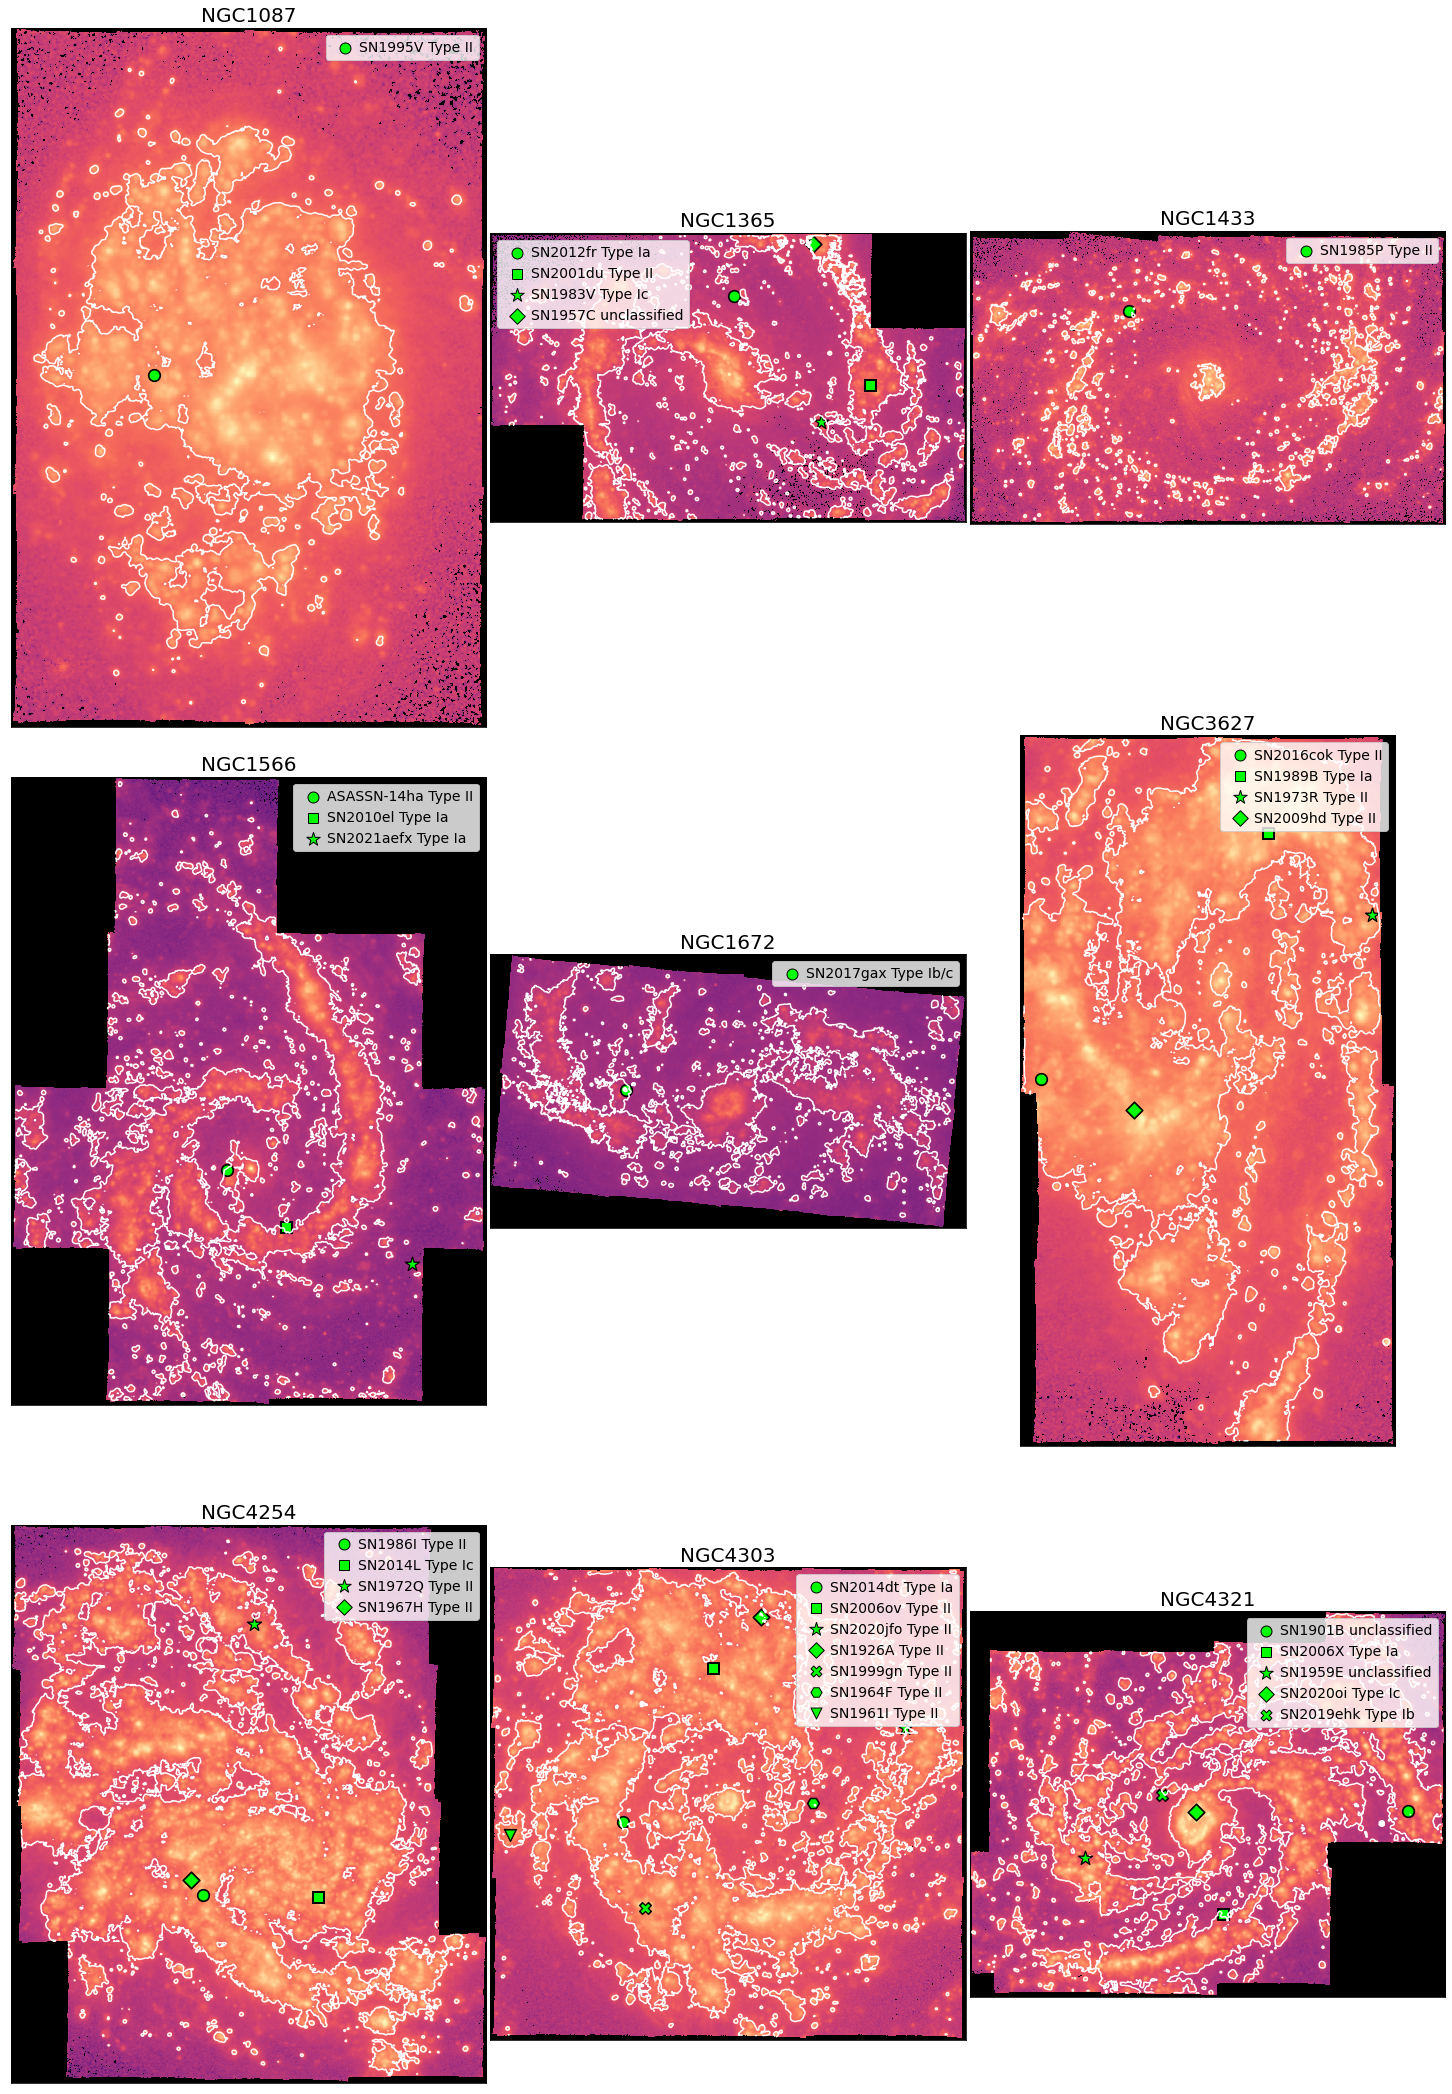

In [123]:
from matplotlib.patches import Circle


markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 30))
for plot in plots:
    # for plotting beam size when we have it
    # draw_circle = plt.Circle((corner[m], corner[m]),ppb[m], fill = True, color = 'white')

    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")
    axs[i][j].set_title(gals[m][0], fontsize=20)
    axs[i][j].contour(sigma[m], [100], colors = ["white"], linestyles = ("-"))
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    #axs[i][j].add_patch(draw_circle)
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], edgecolor="black", label = legendLabels[m][n])
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/AllSNeInMUSEGalaxies.png", dpi=300)
plt.close()

print()